# Image Reconstruction Example

In [1]:
import xarray as xr
import numpy as np

import pyvista as pv
#pv.set_jupyter_backend('html')
pv.set_jupyter_backend('static')
#pv.OFF_SCREEN=True

import cedalion
import cedalion.io
import cedalion.dataclasses as cdc
import cedalion.geometry.registration
import cedalion.geometry.segmentation
import cedalion.plots
import cedalion.xrutils as xrutils
import cedalion.imagereco.tissue_properties
import cedalion.imagereco.forward_model as fw
from cedalion.imagereco.solver import pseudo_inverse_stacked
import cedalion.datasets
from cedalion import units
import pickle
import matplotlib.pyplot as p
import time

xr.set_options(display_expand_data=False);

## Load a finger-tapping dataset 

For this demo we load an example finger-tapping recording through `cedalion.datasets.get_fingertapping`. The file contains a single NIRS element with one block of raw amplitude data. 

Alternatively, use `cedalion.io.read_snirf` to read elements from a snirf file.

In [2]:
elements = cedalion.datasets.get_fingertapping()

The location of the probes is obtained from the snirf metadata (i.e. /nirs0/probe/)

Note that units ('m') are adopted and the coordinate system is named 'digitized'.

In [3]:
geo3d_meas = elements[0].geo3d
display(geo3d_meas)

Magnitude,[[-0.041613204679326624 0.026799775287857947 0.1299043936308115] [-0.06476686499872276 0.05814256998996063 0.0908425773727145] [-0.07120554551675068 -0.012874272652217859 0.10787860947691345] [-0.0859043654400404 0.018971698468891116 0.06509762433137256] [0.03694171596700852 0.02748380530252158 0.13022129709104263] [0.06065133742692848 0.05882414589197514 0.09117717995727878] [0.06712771392323756 -0.012199231886346213 0.1085725493643022] [0.08188685574250908 0.020427932162352107 0.06571325110115192] [-0.037619588707178915 0.06322851630256272 0.11572802770110814] [-0.04134445059646741 -0.011779611291995052 0.13495002938154654] [-0.07242424650162711 0.02347293206381116 0.10322218957482163] [-0.07912592748234686 0.05140929117919257 0.057370046083468226] [0.03352717285472944 0.06359968341212022 0.11583881331702946] [0.03686639505686032 -0.011397164907962862 0.13536724076864515] [0.06791592703520163 0.02468254467119271 0.10366605207860985] [0.075310088095807 0.05226884499005337 0.05787698428594235] [-0.03773895423262196 0.034082658086024245 0.1294919790818403] [-0.061454307897075164 0.06443800208211416 0.09061004226260877] [-0.07282878975853647 -0.00527870527992114 0.10743054838539287] [-0.08439610638498087 0.02706123378098264 0.06559510739262155] [0.040013338219712126 0.020439745814301982 0.13063767506528579] [0.06428020193514211 0.05162125732852231 0.09133632943784001] [0.06521393141744246 -0.019260368037897515 0.10880928230870081] [0.08272091030272573 0.012990608473329186 0.06658402323335233] [-0.0824899918305801 3.5272652784690273e-09 -8.985265795291575e-10] [6.534060185275914e-12 0.11404663614484922 -8.956669156345853e-09] [0.08248999697928468 3.893090638057428e-09 4.766247813092761e-10] [-0.04018770669918394 0.044642295725887106 0.12357659157001165] [-0.04174110787598461 0.007685839199884737 0.13437743644514044] [-0.05885642692737942 0.026136335712672674 0.11745327806321545] [0.03851939726517181 0.03078283979366837 0.1281798987708399] [-0.052808259274512416 0.06188780045911764 0.10403189889709587] [-0.06922421433143165 0.04108974212744533 0.0972095427514579] [-0.07351067792317667 0.05556043944468993 0.07592438053279707] [0.031418413207589764 0.05609701242391968 0.12112072355182572] [-0.05798909959739463 -0.013176608236818512 0.12293491786782985] [-0.07419549041066105 0.00549319711704184 0.10669158774707252] [0.023828589288117673 0.003996293896988853 0.14081960191362605] [-0.08184195746940305 0.022098763709400317 0.08422485645365857] [-0.08309090979477994 0.03520830182778492 0.0610323268526085] [0.026425335781627597 0.043375220063173334 0.12939415639453739] [0.035781770725957916 0.04568049698512951 0.12354633505671649] [0.037556277679295876 0.008001190852073497 0.134555406719549] [0.054080633753515184 0.026705026363902817 0.11818464121484251] [0.06801076312164317 0.02284818084680601 0.10445872040876931] [0.0481712114118228 0.062034828924799924 0.10518292837437133] [0.06461419274656584 0.042329086589563227 0.0977770136200937] [0.06967032405092426 0.05604290375898291 0.07590918892077606] [0.07526945345643418 0.037578919664336574 0.08007431341875021] [0.05288202968424921 -0.012139614237985343 0.12430811820847815] [0.06938013615060833 0.0069016618704050535 0.10806432085401242] [0.07932239267332403 -0.00044800545870984573 0.08903670686337778] [0.07756024143390347 0.022515587935674892 0.08578432016555051] [0.07912303758068968 0.036496511669642975 0.06257633565753129] [0.08225821050778642 0.01751423306824721 0.06619028345490524]]
Units,meter


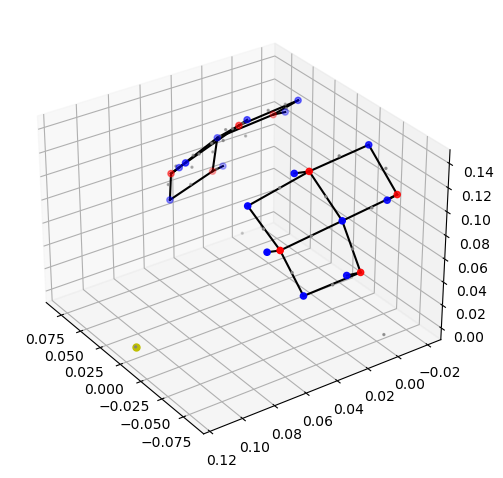

In [4]:
cedalion.plots.plot_montage3D(elements[0].data[0], geo3d_meas)

The measurement list is a `pandas.DataFrame` that describes which source detector pairs form channels.

In [5]:
meas_list = elements[0].measurement_lists[0]
display(meas_list.head(5))

,sourceIndex,detectorIndex,wavelengthIndex,wavelengthActual,wavelengthEmissionActual,dataType,dataUnit,dataTypeLabel,dataTypeIndex,sourcePower,detectorGain,moduleIndex,sourceModuleIndex,detectorModuleIndex,channel,source,detector,wavelength,chromo
0,1,1,1,None,None,1,None,None,1,None,None,None,None,None,S1D1,S1,D1,760.0,None
1,1,1,2,None,None,1,None,None,1,None,None,None,None,None,S1D1,S1,D1,850.0,None
2,1,2,1,None,None,1,None,None,1,None,None,None,None,None,S1D2,S1,D2,760.0,None
3,1,2,2,None,None,1,None,None,1,None,None,None,None,None,S1D2,S1,D2,850.0,None
4,1,3,1,None,None,1,None,None,1,None,None,None,None,None,S1D3,S1,D3,760.0,None


For this demo select 20 seconds after a trial starts at t=117s and transform raw amplitudes to optical density.

In [6]:
raw_amp = elements[0].data[0]
od = -np.log( raw_amp/ raw_amp.mean("time"))
od = od.sel(time=(od.time > 117) & (od.time < 137))
display(od)

Magnitude,[[[0.06918034466317638 0.07401752852572 0.07071229698416719 ... 0.051619403589263375 0.0495220175864485 0.05733235703931382] [0.06921202157214147 0.061501212231445265 0.05590604249360677 ... 0.04599081385223266 0.043607764540203944 0.04094819142249005]] [[0.020041872368480568 0.016576682916502616 0.014722865607337156 ... -0.002784054835008663 -0.0007689352312300937 -0.0020895073582459776] [0.009813111987445769 0.00897044867652182 0.0011997665832353638 ... -0.010198135446196304 -0.010370950115019007 -0.011470186156567192]] [[0.10594320729699594 0.11040552098988785 0.09790654829835266 ... 0.08426551590972008 0.07950323340766452 0.08127791067147398] [0.08055700293463454 0.08123576263128784 0.06966574535920377 ... 0.06093385202767259 0.061257585432739924 0.05823648160949095]] ... [[0.12912497810328413 0.11565864080248257 0.13079567642557186 ... 0.10849014054100535 0.10294095349558663 0.10024426020832462] [0.10930812491582625 0.10186119471837832 0.12604836057042149 ... 0.09335904696314679 0.09014934668122512 0.08308516523442286]] [[0.15073497697757607 0.14401735613117914 0.15809084166771298 ... 0.12948848077454567 0.12840557323576637 0.12210415383327351] [0.143315751044253 0.13607805147328417 0.15976779663350146 ... 0.12080230738717117 0.11483180494527613 0.10851376722360422]] [[0.04657970613492235 0.044430170657312675 0.04896207126856559 ... 0.044799036592813875 0.0442726185812929 0.042864201883683846] [0.032467942674174056 0.02972500729866644 0.03526754672420242 ... 0.02940133059028687 0.028862946988339515 0.027506374441424314]]]
Units,dimensionless


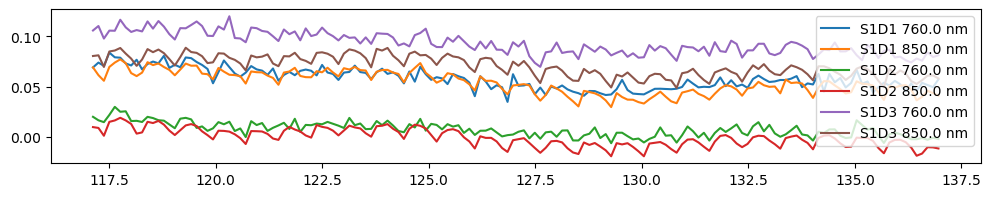

In [7]:
p.figure(figsize=(12,2))
for ch in ["S1D1", "S1D2", "S1D3"]:
    for wl in od.wavelength.values:
        p.plot(od.time, od.sel(channel=ch, wavelength=wl), label=f"{ch} {wl} nm")
p.legend();

## Load segmented MRI scan

For this example use a segmentation of the Colin27 average brain.

In [8]:
SEG_DATADIR, mask_files, landmarks_file = cedalion.datasets.get_colin27_segmentation()

The segmentation masks are in individual niftii files. The dict `mask_files` maps mask filenames relative to `SEG_DATADIR` to short labels. These labels describe the tissue type of the mask. 

In principle the user is free to choose these labels. However, they are later used to lookup the tissue's optical properties. So they must be map to one of the tabulated tissue types (c.f. `cedalion.imagereco.tissue_properties.TISSUE_LABELS`).

The variable `landmarks_file` holds the path to a file containing landmark positions in scanner space (RAS). This file can be created with Slicer3D.

In [9]:
display(SEG_DATADIR)
display(mask_files)
display(landmarks_file)

'/home/eike/.cache/cedalion/colin27_segmentation.zip.unzip/colin27_segmentation'

{'csf': 'mask_csf.nii',
 'gm': 'mask_gray.nii',
 'scalp': 'mask_skin.nii',
 'skull': 'mask_bone.nii',
 'wm': 'mask_white.nii'}

'landmarks.mrk.json'

## Coordinate systems

Up to now we have geometrical data from three different coordinate reference systems (CRS):

- The optode positions are in one space `CRS='digitized'` and the coordinates are in meter. In our example the origin is at the head center and y-axis pointing in the superior direction. Other digitization tools can use other units or coordinate systems.
- The segmentation masks are in voxel space (`CRS='ijk'`) in which the voxel edges are aligned with the coordinate axes. Each voxel has unit edge length, i.e. coordinates are dimensionless. 
  Axis-aligned grids are computationally efficient, which is why the photon simulation code (MCX) uses this coordinate system.
- The voxel space (`CRS='ijk'`) is related to scanner space (`CRS='ras'` or `CRS='aligned'`) in which coordinates have physical units and coordinate axes point to the (r)ight, (a)nterior and s(uperior) directions. The relation between both spaces is given through an affine transformation (e.g. `t_ijk2ras`). When loading the segmentation masks in Slicer3D this transformation is automatically applied. Hence, the picked landmark coordinates are exported in RAS space.

  The niftii file provides a string label for the scanner space. In this example the RAS space is called 'aligned' because the masks are aligned to another MRI scan.


To avoid confusion between these different coordinate systems, `cedalion` tries to be explicit about which CRS a given point cloud or surface is in.

## The TwoSurfaceHeadModel

The photon propagation considers the complete MRI scan, in which each voxel is attributed to one tissue type with its respective optical properties. However, the image reconstruction does not intend to reconstruct absorption changes in each voxel. The inverse problem is simplified, by considering only two surfaces (scalp and brain) and reconstruct only absorption changes in voxels close to these surfaces.

The class `cedalion.imagereco.forward_model.TwoSurfaceHeadModel` groups together the segmentation mask, landmark positions and affine transformations as well as the scalp and brain surfaces. The brain surface is calculated by grouping together white and gray matter masks. The scalp surface encloses the whole head.

In [10]:
head = fw.TwoSurfaceHeadModel.from_segmentation(
    segmentation_dir=SEG_DATADIR,
    mask_files = mask_files,
    landmarks_ras_file=landmarks_file
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [11]:
head.segmentation_masks

<xarray.DataArray (segmentation_type: 5, i: 255, j: 255, k: 189)>
0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Coordinates:
  * segmentation_type  (segmentation_type) <U5 'csf' 'gm' 'scalp' 'skull' 'wm'
Dimensions without coordinates: i, j, k

In [12]:
head.landmarks

Magnitude,[[126.95007602492133 206.78946685785218 57.85887908931255] [128.75606727601308 26.05000305176989 39.142013549813676] [55.050003051731764 110.88059425351402 39.34302139280303] [202.94999694821513 113.96190643307837 39.922157287577626]]
Units,dimensionless


In [13]:
head.brain

TrimeshSurface(mesh=<trimesh.Trimesh(vertices.shape=(29986, 3), faces.shape=(60000, 3))>, crs='ijk', units=<Unit('dimensionless')>)

In [14]:
head.scalp

TrimeshSurface(mesh=<trimesh.Trimesh(vertices.shape=(30141, 3), faces.shape=(59999, 3))>, crs='ijk', units=<Unit('dimensionless')>)

`TwoSurfaceHeadModel.from_segmentation` converts everything into voxel space (`CRS='ijk'`)

In [15]:
head.crs

'ijk'

The transformation matrix to translate from voxel to scanner space:

In [16]:
head.t_ijk2ras

Magnitude,[[1.0 0.0 0.0 -127.0] [0.0 1.0 0.0 -127.0] [0.0 0.0 1.0 -94.0] [0.0 0.0 0.0 1.0]]
Units,millimeter


Changing between coordinate systems:

In [17]:
head_ras = head.apply_transform(head.t_ijk2ras)
display(head_ras.crs)
display(head_ras.brain)

'aligned'

TrimeshSurface(mesh=<trimesh.Trimesh(vertices.shape=(29986, 3), faces.shape=(60000, 3))>, crs='aligned', units=<Unit('millimeter')>)

## Optode Registration
The optode coordinates from the recording must be aligned with the scalp surface. Currently, `cedaĺion` offers a simple registration method, which finds an affine transformation (scaling, rotating, translating) that matches the landmark positions of the head model and their digitized counter parts. Afterwards, optodes are snapped to the nearest vertex on the scalp.

In [18]:
geo3d_snapped_ijk = head.align_and_snap_to_scalp(geo3d_meas)
display(geo3d_snapped_ijk)

Magnitude,[[85.72451853423377 115.81093042160249 166.02482361020014] [66.58585328060681 149.44532320378326 129.41402784179195] [58.68738261185285 79.65353592782442 132.60613446761826] [52.93409226872556 111.95227713454288 96.92775672143013] [168.512929089735 117.06879070597579 167.76211746592125] [188.3947159776755 150.9659181589596 131.96860789728] [198.31052016765443 82.41701808819201 134.4517326120179] [203.29985639562776 119.99461698195316 99.8459874678056] [88.23884258748399 148.8295530796518 157.63272407261798] [83.44878366779845 72.87102662463867 164.67692201657405] [59.737943024536165 114.68789442876415 135.62792074303826] [57.93382469838729 144.01274961274999 98.09085504987145] [165.49822082361075 153.2779600894446 157.459397688325] [169.83676910508126 75.60645704250669 168.47766597277854] [197.31045921047223 117.47262574474534 134.6318006441893] [197.10299366586895 150.85138565034694 101.65173564403321] [88.23578106844886 121.31778590291009 166.53151077518754] [67.63890025164366 151.45475661790957 130.52073079535484] [57.88789714978513 86.60094119826587 133.0766407617362] [53.87528217402319 123.90074097195713 101.88271098963398] [173.7468818719508 110.66324440566564 165.436913805255] [192.29547272227256 143.62028509955175 129.60933787923952] [197.35325856791454 76.61603712893259 134.54765809471598] [204.27721582716453 113.9100008483077 99.11838119983098] [56.646507926511035 108.92575258579011 38.64929416542201] [126.27895152708297 206.1436859661639 56.862357570708156] [202.12725782551666 112.25227197289388 38.854606640783] [87.22952326530478 130.31854279916553 163.52640727312343] [85.34040254192014 96.80578342949566 168.4760057891351] [69.22056120373611 116.2769152447859 150.43003261668707] [168.88694237951185 121.61979537712638 166.36526245723869] [74.80595871196681 148.9566176716167 143.798357266533] [61.96096557856202 130.3339094499413 133.4927606792553] [59.89758148503303 146.418073943737 114.0861059221889] [163.3208249739936 141.4222306802507 164.1445570995035] [69.47864683662708 75.67428358585768 151.77568597491643] [57.65371159375694 98.44541501983294 133.99099321596307] [158.27694494155088 88.60325754949142 176.2304377223727] [54.7028047421239 115.5431889885556 116.57348255127532] [54.897634295761044 130.86207868152974 96.27873381165469] [159.07353319465457 132.29733109131425 169.33933801398538] [167.71167509276955 133.95954041714532 163.70764491232353] [170.62933199369309 97.52509148298738 169.51356567236937] [185.2430148808628 119.53420652966875 152.9081792112222] [196.34868326249548 116.77414193050309 137.40279545255757] [178.60684798392708 152.68580266602459 144.91033172206266] [193.36899476471035 134.08905087139144 134.14798409763895] [195.16835053850298 150.21841757475917 114.11144017893959] [199.30829705569275 133.55192380062743 115.5911886806671] [186.87471547734356 79.75694257861544 154.2954764991826] [198.23130339348234 102.40955893677774 137.26792076464918] [203.05285437790005 97.10606856076748 117.12836230509868] [201.33010172394756 119.48478116679865 118.57520595684117] [200.2974191651336 134.9961986950234 101.85680043302257] [204.06663600242447 114.95642497687382 99.92790902078382]]
Units,dimensionless


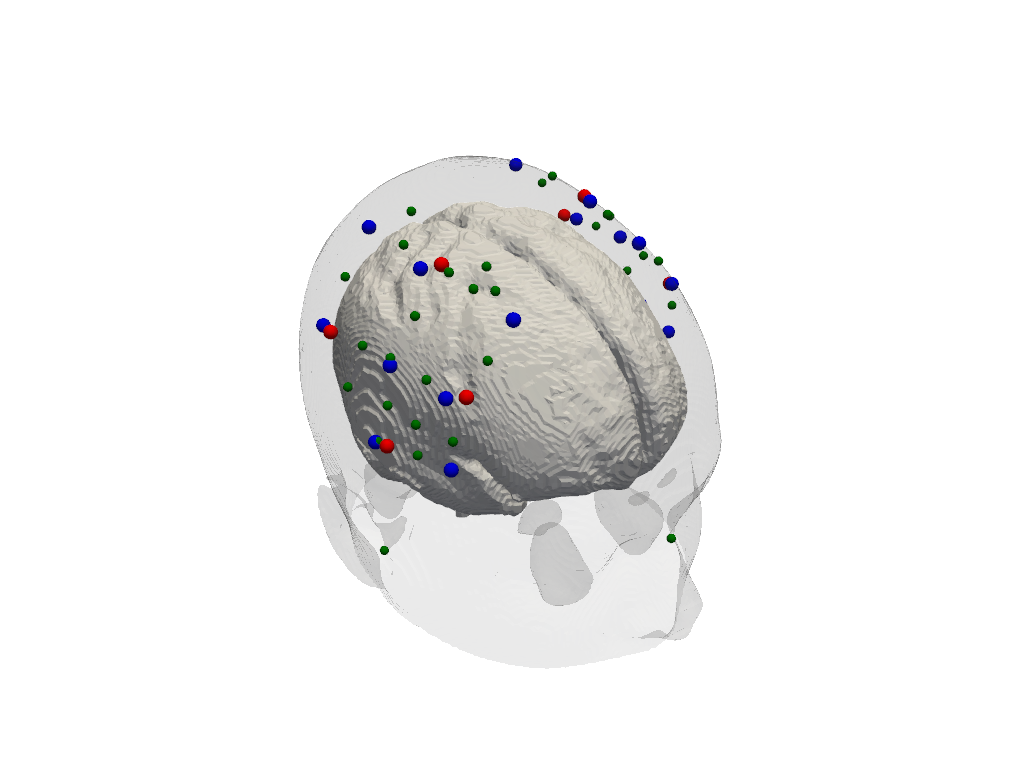

In [19]:
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, head.brain, color="w")
cedalion.plots.plot_surface(plt, head.scalp, opacity=.1)
cedalion.plots.plot_labeled_points(plt, geo3d_snapped_ijk)
plt.show()

## Simulate light propagation in tissue with MCX

`cedalion.imagereco.forward_model.ForwardModel` is a wrapper around pmcx. Using the data in the head model it prepares the inputs for pmcx and offers functionality to calculate the sensitivty matrix.

In [20]:
fwm = cedalion.imagereco.forward_model.ForwardModel(head, geo3d_snapped_ijk, meas_list)

### Run the simulation

The `compute_fluence` method puts a simulated light source at each optode positions and calulcates the fluence in each voxel.

In [21]:
fluence_all, fluence_at_optodes = fwm.compute_fluence()

simulating fluence for S1. 1 / 24
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 1
allocate 24579450 floats [12289725 1 0]
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes 

tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 1
allocate 24579450 floats [12289725 1 0]
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for re

tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 1
allocate 24579450 floats [12289725 1 0]
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for re

tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 1
allocate 24579450 floats [12289725 1 0]
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for re

simulating fluence for D9. 17 / 24
nphoton: 1e+08
tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 1
allocate 24579450 floats [12289725 1 0]
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes

tstart: 0
tstep: 5e-09
tend: 5e-09
isnormalized: 1
issrcfrom0: 1
unitinmm: 1
issavedet: 1
allocate 24579450 floats [12289725 1 0]
###############################################################################
#                      Monte Carlo eXtreme (MCX) -- CUDA                      #
#          Copyright (c) 2009-2023 Qianqian Fang <q.fang at neu.edu>          #
#                https://mcx.space/  &  https://neurojson.org/                #
#                                                                             #
# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #
#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #
###############################################################################
#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #
###############################################################################
#  Open-source codes and reusable scientific data are essential for re

simulated 100000000 photons (100000000) with 335872 threads (repeat x1)
MCX simulation speed: 36751.19 photon/ms
total simulated energy: 100000000.00	absorbed: 47.92851%
(loss due to initial specular reflection is excluded in the total)


The photon simulation yields the fluence in each voxel fo each wavelength.

In [22]:
fluence_all

<xarray.DataArray (label: 24, wavelength: 2, i: 255, j: 255, k: 189)>
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Coordinates:
  * label       (label) <U3 'S1' 'S2' 'S3' 'S4' 'S5' ... 'D13' 'D14' 'D15' 'D16'
    type        (label) object PointType.SOURCE ... PointType.DETECTOR
  * wavelength  (wavelength) float64 760.0 850.0
Dimensions without coordinates: i, j, k

Also, for a each combination of two optodes, the fluence in the voxels at the optode positions is calculated.

In [23]:
fluence_at_optodes

<xarray.DataArray (optode1: 24, optode2: 24, wavelength: 2)>
0.06157 0.06157 2.258e-08 2.258e-08 ... 1.221e-08 1.221e-08 0.2147 0.2147
Coordinates:
  * optode1     (optode1) <U3 'S1' 'S2' 'S3' 'S4' ... 'D13' 'D14' 'D15' 'D16'
  * optode2     (optode2) <U3 'S1' 'S2' 'S3' 'S4' ... 'D13' 'D14' 'D15' 'D16'
  * wavelength  (wavelength) float64 760.0 850.0

## Plot fluence

To illustrate the tissue probed by light travelling from a source to the detector two fluence profiles need to be multiplied. 

/opt/miniconda3/envs/cedalion2/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


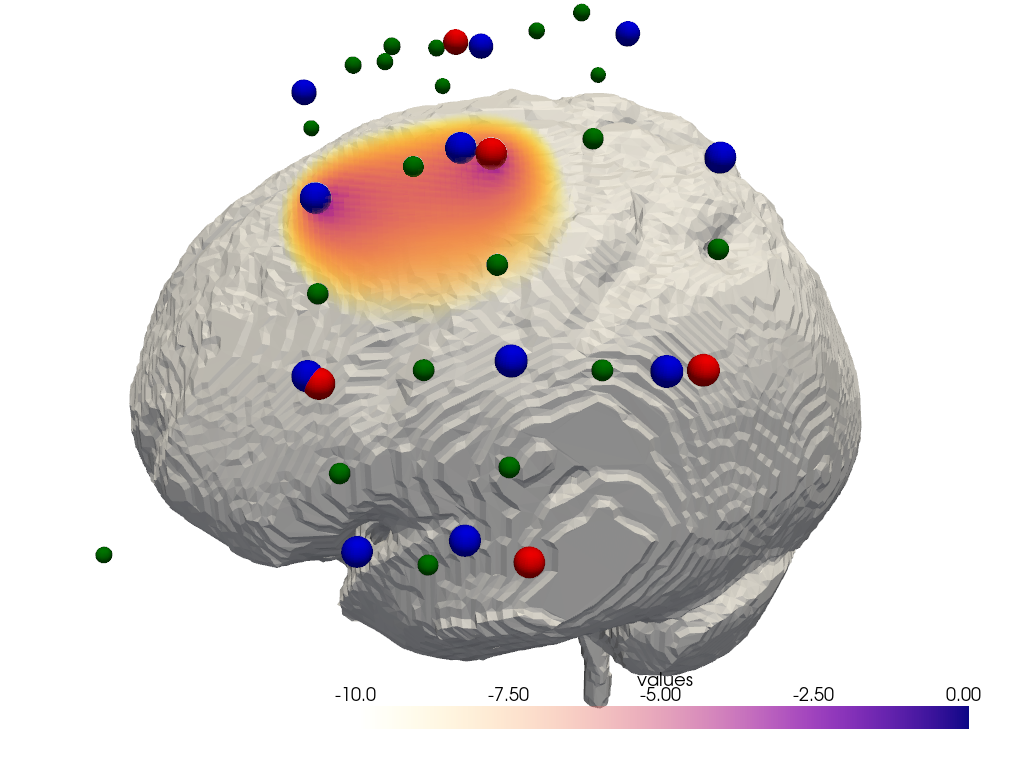

In [24]:
time.sleep(1)

plt = pv.Plotter()

f = fluence_all.loc["S1", 760].values * fluence_all.loc["D1",760].values
f[f==0] = f[f!=0].min()
f = np.log10(f)
vf = pv.wrap(f)

plt.add_volume(
    vf,
    log_scale=False, 
    cmap='plasma_r',
    clim=(-10,0),
)
cedalion.plots.plot_surface(plt, head.brain, color="w")
cedalion.plots.plot_labeled_points(plt, geo3d_snapped_ijk)

cog = head.brain.vertices.mean("label").values
plt.camera.position = cog + [-300,30, 150]
plt.camera.focal_point = cog 
plt.camera.up = [0,0,1] 
#plt.reset_camera()

plt.show()

### Calculate the sensitivity matrices

The sensitivity matrix describes the effect of an absorption change at a given surface vertex on the OD recording in a given channel and at given wavelength. The coordinate `is_brain` holds a mask to distinguish brain and scalp voxels.

In [25]:
Adot = fwm.compute_sensitivity(fluence_all, fluence_at_optodes)
Adot

<xarray.DataArray (channel: 28, vertex: 60127, wavelength: 2)>
1.812e-15 1.812e-15 2.43e-16 2.43e-16 ... 2.059e-20 2.639e-19 2.639e-19
Coordinates:
  * channel     (channel) <U5 'S1D1' 'S1D2' 'S1D3' ... 'S8D7' 'S8D8' 'S8D16'
  * wavelength  (wavelength) float64 760.0 850.0
    is_brain    (vertex) bool True True True True ... False False False False
Dimensions without coordinates: vertex

The sensitivity `Adot` has shape (nchannel, nvertex, nwavelenghts). To solve the inverse problem we need a matrix that relates OD in channel space to absorption in image space. Hence, the sensitivity must include the extinction coefficients to translate between OD and concentrations. Furthermore, channels at different wavelengths must be  stacked as well vertice and chromophores into new dimensions (flat_channel, flat_vertex):

$$ \left( \begin{matrix} OD_{c_1, \lambda_1} \\ \vdots \\ OD_{c_N,\lambda_1} \\ OD_{c_1,\lambda_2} \\ \vdots \\ OD_{c_N,\lambda_2} \end{matrix}\right) = A \cdot
\left( \begin{matrix} \Delta c_{v_1, HbO} \\ \vdots \\ \Delta c_{v_N, HbO} \\ \Delta c_{v_1, HbR} \\ \vdots \\ \Delta c_{v_N, HbR} \end{matrix}\right) $$

In [26]:
Adot_stacked = fwm.compute_stacked_sensitivity(Adot)
Adot_stacked

/opt/miniconda3/envs/cedalion2/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


<xarray.DataArray (flat_channel: 56, flat_vertex: 120254)>
2.444e-13 3.278e-14 0.0 1.825e-12 ... 4.81e-17 1.206e-24 3.277e-18 4.2e-17
Dimensions without coordinates: flat_channel, flat_vertex

### Invert the sensitivity matrix

In [27]:
B = pseudo_inverse_stacked(Adot_stacked)
B

<xarray.DataArray (flat_vertex: 120254, flat_channel: 56)>
-1.063e-11 -1.261e-12 1.067e-11 7.787e-12 ... -1.324e-24 1.929e-25 -8.774e-25
Dimensions without coordinates: flat_vertex, flat_channel

### Calculate concentration changes

- the optical density has shape (nchannel, nwavelength, time) -> stack it

In [28]:
od

Magnitude,[[[0.06918034466317638 0.07401752852572 0.07071229698416719 ... 0.051619403589263375 0.0495220175864485 0.05733235703931382] [0.06921202157214147 0.061501212231445265 0.05590604249360677 ... 0.04599081385223266 0.043607764540203944 0.04094819142249005]] [[0.020041872368480568 0.016576682916502616 0.014722865607337156 ... -0.002784054835008663 -0.0007689352312300937 -0.0020895073582459776] [0.009813111987445769 0.00897044867652182 0.0011997665832353638 ... -0.010198135446196304 -0.010370950115019007 -0.011470186156567192]] [[0.10594320729699594 0.11040552098988785 0.09790654829835266 ... 0.08426551590972008 0.07950323340766452 0.08127791067147398] [0.08055700293463454 0.08123576263128784 0.06966574535920377 ... 0.06093385202767259 0.061257585432739924 0.05823648160949095]] ... [[0.12912497810328413 0.11565864080248257 0.13079567642557186 ... 0.10849014054100535 0.10294095349558663 0.10024426020832462] [0.10930812491582625 0.10186119471837832 0.12604836057042149 ... 0.09335904696314679 0.09014934668122512 0.08308516523442286]] [[0.15073497697757607 0.14401735613117914 0.15809084166771298 ... 0.12948848077454567 0.12840557323576637 0.12210415383327351] [0.143315751044253 0.13607805147328417 0.15976779663350146 ... 0.12080230738717117 0.11483180494527613 0.10851376722360422]] [[0.04657970613492235 0.044430170657312675 0.04896207126856559 ... 0.044799036592813875 0.0442726185812929 0.042864201883683846] [0.032467942674174056 0.02972500729866644 0.03526754672420242 ... 0.02940133059028687 0.028862946988339515 0.027506374441424314]]]
Units,dimensionless


In [29]:
od_stacked = od.stack({"flat_channel" : ["wavelength", "channel"]})
display(od_stacked)

Magnitude,[[0.06918034466317638 0.020041872368480568 0.10594320729699594 ... 0.10930812491582625 0.143315751044253 0.032467942674174056] [0.07401752852572 0.016576682916502616 0.11040552098988785 ... 0.10186119471837832 0.13607805147328417 0.02972500729866644] [0.07071229698416719 0.014722865607337156 0.09790654829835266 ... 0.12604836057042149 0.15976779663350146 0.03526754672420242] ... [0.051619403589263375 -0.002784054835008663 0.08426551590972008 ... 0.09335904696314679 0.12080230738717117 0.02940133059028687] [0.0495220175864485 -0.0007689352312300937 0.07950323340766452 ... 0.09014934668122512 0.11483180494527613 0.028862946988339515] [0.05733235703931382 -0.0020895073582459776 0.08127791067147398 ... 0.08308516523442286 0.10851376722360422 0.027506374441424314]]
Units,dimensionless


In [30]:
dC = B @ od_stacked
dC

Magnitude,[[8.304849989180434e-11 7.748130676584134e-11 8.989703532567366e-11 ... 5.856025527348974e-11 5.913267004549956e-11 4.784689922811798e-11] [4.2719976858519915e-11 3.985051173119309e-11 4.654439168639545e-11 ... 2.8953867562376182e-11 2.9376509495312126e-11 2.3161676557400446e-11] [0.0 0.0 0.0 ... 0.0 0.0 0.0] ... [2.4587762269888612e-32 2.509011426215539e-32 2.5464471206326804e-32 ... 2.417999478115288e-32 2.519686044710634e-32 2.49521517836613e-32] [6.679722820463511e-26 6.816195637301989e-26 6.917892657215158e-26 ... 6.568934857697984e-26 6.845193096516093e-26 6.778710052860887e-26] [8.566082922566855e-25 8.74048385148989e-25 8.865388275822174e-25 ... 8.409823216402954e-25 8.77480268081887e-25 8.684879381432474e-25]]
Units,dimensionless


## Plot concentration changes

Using functionality from pyvista and VTK plot the concentration changes on the brain and scalp surfaces.

In [31]:
b = cdc.VTKSurface.from_trimeshsurface(head.brain)
b = pv.wrap(b.mesh)
s = cdc.VTKSurface.from_trimeshsurface(head.scalp)
s = pv.wrap(s.mesh)

In [32]:
hbo = dC[:dC.shape[0]//2, :].pint.dequantify()
hbo_brain = hbo[(Adot.is_brain == True).values,:]
hbo_scalp = hbo[(Adot.is_brain == False).values,:]


i = 10
tt = od.time[i]
b["reco_hbo"] = (hbo_brain[:,i] - hbo_brain[:,0])
s["reco_hbo"] = (hbo_scalp[:,i] - hbo_scalp[:,0])

/opt/miniconda3/envs/cedalion2/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


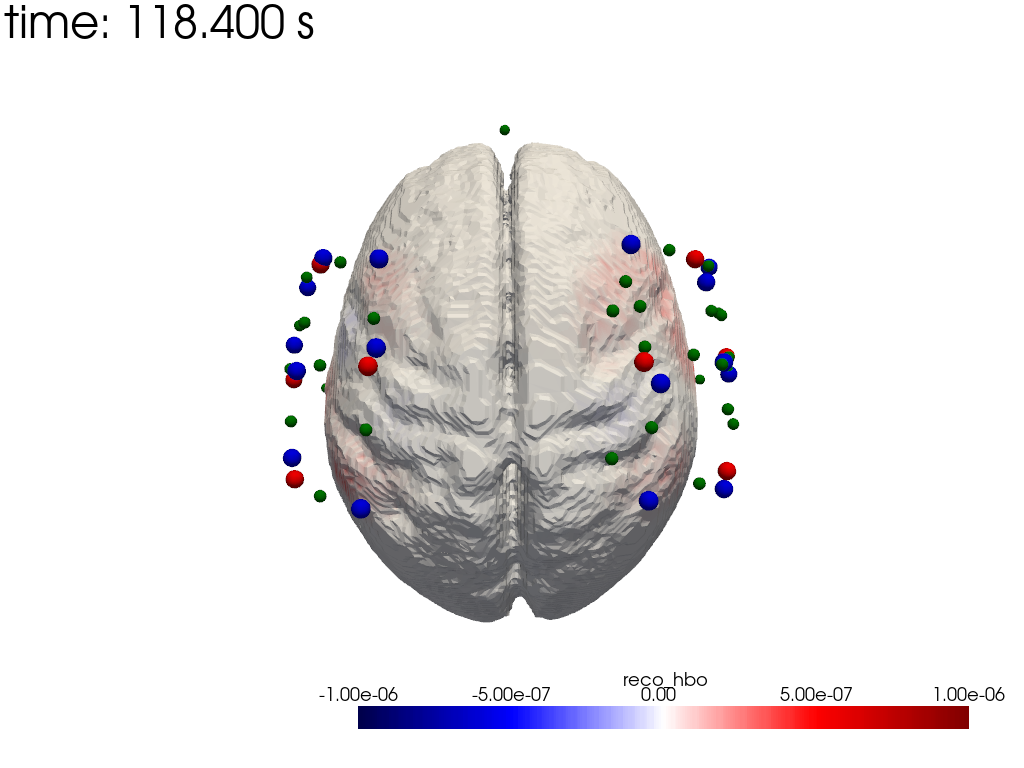

In [33]:
# plot brain surface
plt = pv.Plotter()
    
plt.add_mesh(
    b,
    scalars="reco_hbo",
    cmap='seismic', # 'gist_earth_r', 
    clim=(-10e-7,10e-7),
)

cog = head.brain.vertices.mean("label").values
plt.camera.position = cog + [0,0,400]
plt.camera.focal_point = cog 
plt.camera.up = [0,1,0] 
plt.reset_camera()

plt.add_text(f"time: {tt:.3f} s")
cedalion.plots.plot_labeled_points(plt, geo3d_snapped_ijk)
plt.show()

/opt/miniconda3/envs/cedalion2/lib/python3.10/site-packages/xarray/core/variable.py:309: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  data = np.asarray(data)


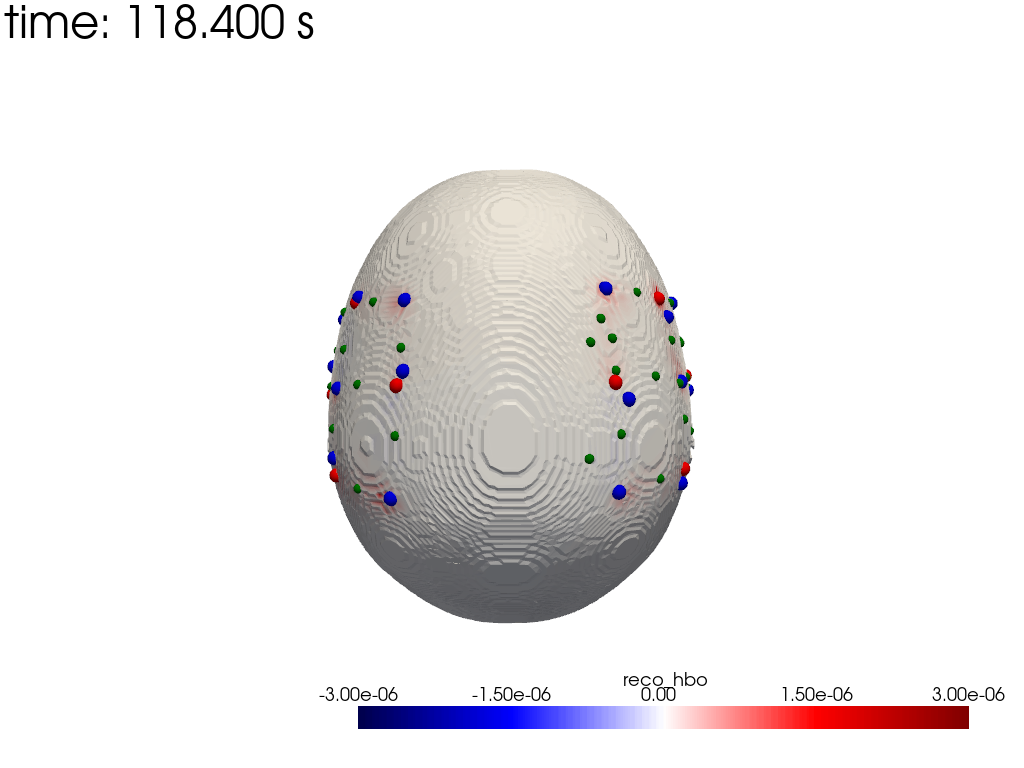

In [34]:
# plot scalp
plt = pv.Plotter()
    
plt.add_mesh(
    s,
    scalars="reco_hbo",
    cmap='seismic', # 'gist_earth_r', 
    clim=(-3e-6,3e-6),
)

cog = head.brain.vertices.mean("label").values
plt.camera.position = cog + [0,0,400]
plt.camera.focal_point = cog 
plt.camera.up = [0,1,0] 
plt.reset_camera()

plt.add_text(f"time: {tt:.3f} s")
cedalion.plots.plot_labeled_points(plt, geo3d_snapped_ijk)
plt.show()